In [1]:
w_python = !which python
if 'home' in w_python[0]:
    pass
else:
    !pip install watermark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !conda install -y watermark

In [2]:
%load_ext watermark
%watermark

Last updated: 2022-08-06T15:40:28.406251+00:00

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.188+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



In [3]:
from sklearn.datasets import fetch_lfw_people

import matplotlib.pyplot as plt

from scipy.linalg import svd

import numpy as np

from ipywidgets import IntSlider, interact

# Resume

SVD puede ser utilizado para comprimir imágenes, extrayendo aquellos componentes que son fundamentales a la hora de representar lo que hay en las imágenes y eliminando el resto (el ruido).

Para este ejemplo vamos a usar el dataset [Labeled Faces in the Wild (LFW)](http://vis-www.cs.umass.edu/lfw/) que contiene un conjunto de imágenes de personajes famosos enfocado al reconocimiento facial (y que es un dataset desarrollado por la universidad donde hice mi proyecto final de carrera, **let's go UMASS!**)

El dataset consiste de 3020 imágenes de famosos (los famosos aparecen múltiples veces). La variable objetivo es el nombre del famoso.

Las imágenes son básicamente arrays de numeros donde cuanto mayor sea el número más claro es el píxel (son imágenes de tamaño 87 pixeles de anchura por 65 de altura).

# Data Collection

https://www.udemy.com/course/aprende-data-science-y-machine-learning-con-python/learn/lecture/8309620#overview

In [9]:
lfw_people = fetch_lfw_people(min_faces_per_person=50, resize=1)
lfw_people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

Nombre de las personas

In [10]:
lfw_people.target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Jacques Chirac',
       'Jean Chretien', 'John Ashcroft', 'Junichiro Koizumi',
       'Serena Williams', 'Tony Blair'], dtype='<U17')

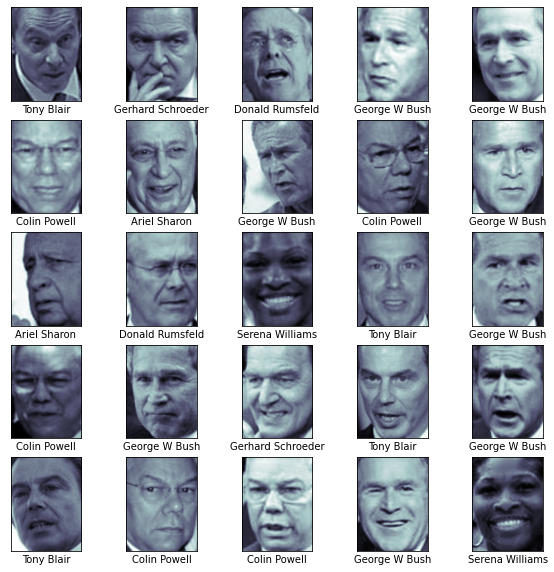

In [11]:
plt.rcParams['figure.figsize'] = (10, 10)
fig, ax = plt.subplots(5, 5)

for i, axi in enumerate(ax.flat):
    axi.imshow(lfw_people.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=lfw_people.target_names[lfw_people.target[i]])

plt.show()

Mostrando una cara

In [12]:
def dibujar_cara(matriz_cara):
    plt.figure(figsize=(9,6))
    plt.imshow(matriz_cara, cmap='gray');

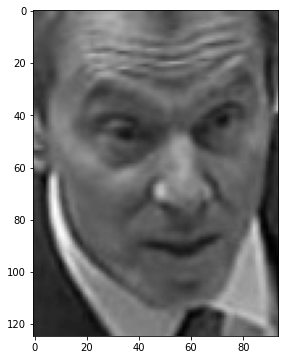

In [13]:
dibujar_cara(lfw_people.images[0])

Tamaño de la imagen en KB

In [14]:
def kb_totales(*arrays):
    return sum(map(lambda a: a.nbytes, arrays)) / 1024

In [15]:
kb_totales(lfw_people.images[0])

45.8984375

# Processing

Para hacer una descomposición SVD completa podemos usar el método [`scipy.linalg.svd`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html#numpy.linalg.svd).

In [16]:
U, s, V = svd(lfw_people.images[0], full_matrices=True)
U.shape, s.shape, V.shape

((125, 125), (94,), (94, 94))

Vemos que el método svd no devuelve la matriz de valores singulares Sigma como matriz, sino como vector (el resto de elementos son 0). La convertimos a una matriz diagonal de tamaño $87\times65$.

In [17]:
S = np.zeros((U.shape[0], V.shape[0]))
S[:V.shape[0], :V.shape[0]] = np.diag(s)
S.shape

(125, 94)

In [18]:
S

array([[10880.54296875,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,  1833.3927002 ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,  1384.26708984, ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])

Podemos recomponer la imagen original haciendo el producto de las matrices U, S y V.

In [19]:
cara_svd = U @ S @ V

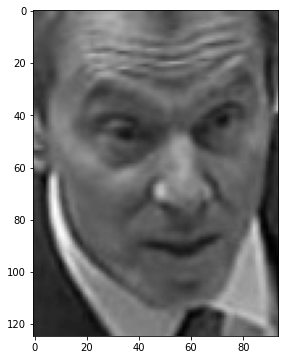

In [20]:
dibujar_cara(lfw_people.images[0])

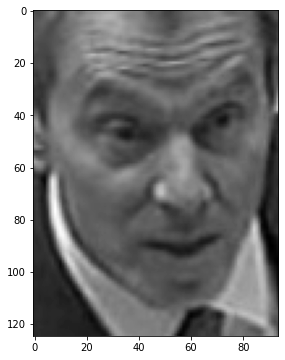

In [21]:
dibujar_cara(cara_svd)

In [22]:
kb_totales(U, s, V)

95.91796875

Vemos que las matrices factores de la imagen ocupan más tamaño que la imagen original (47 kb versus 22 kb). Sin embargo, hemos realizado una descomposición total (**Full SVD**).

Se puede descomponer usando un número específico de valroes singulares **K** que sea menor que d y utilizarlos para recomponer la imagen a costa de perder algo de información.

In [23]:
@interact(img_pos=IntSlider(10, min=0, max=lfw_people.target.size - 1), k=IntSlider(65, min=1, max=65))
def evaluar_k_imagen(img_pos, k):
    Ux, sx, Vx = np.linalg.svd(lfw_people.images[img_pos], full_matrices=True)

    U_k = Ux[:, :k]
    s_k = sx[:k]
    V_k = Vx[:k, :]

    memoria_real = kb_totales(lfw_people.images[img_pos])
    memoria_k = kb_totales(U_k, s_k, V_k)

    # Calculamos la reduccion en tamaño respecto a la imagen original
    pct_reduccion = 100 * (1 - (memoria_k / memoria_real))
    imagen_k_svd = U_k @ np.diag(s_k) @ V_k
    dibujar_cara(imagen_k_svd)
    
    target = lfw_people.target[img_pos]
    target_name = lfw_people.target_names[target]

    plt.title("{} valores singulares, tamaño real: {:.1f} kb, tamaño: {:.1f} kb ({:.1f}% menor), target name: {}".format(k, memoria_real, memoria_k, 
                                                                                                                         pct_reduccion, target_name), size=20)

    plt.show()

interactive(children=(IntSlider(value=10, description='img_pos', max=1559), IntSlider(value=65, description='k…